<h1 align="center"><b>Efficient EMNIST Compression with Autoencoders</b></h1>

<h3 align="center">Building an efficient autoencoder model for compressing the EMNIST dataset</h3>

---
---

## Introduction
In this exploration, I focus on the application of autoencoders for the task of data compression. My dataset of choice is the widely recognized EMNIST-Balanced dataset, which consists of 28 $\times$ 28 pixel grayscale images of handwritten digits and lowercase&uppercase English alphabets.

The EMNIST-Balanced dataset, commonly used in image processing and machine learning, presents an ideal platform for us to demonstrate the capabilities of autoencoders. These sophisticated neural network models are adept at learning efficient representations of data, making them perfect for compression tasks.

## Table of Contents
1. [Import necessary libraries](#Import-necessary-libraries)
2. [Data Acquisition](#Data-Acquisition)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Architecture](#Model-Architecture)
5. [Model Training](#Model-Training)
6. [Model Evaluation](#Model-Evaluation)
7. [Measuring the loss of information through Autoencoder](#Measuring-the-loss-of-information-through-Autoencoder)

---
---

<a id="Import necessary libraries"></a>
## Import necessary libraries

In [1]:
# Data Handling and Numerical Libraries
import random
import numpy as np
import matplotlib.pyplot as plt             

# Keras - Deep Learning API
import keras                                # High-level neural networks API
from extra_keras_datasets import emnist     # EMNIST dataset of hand-written digits and lowercase+uppercase English alphabets
from keras import backend as K 
from keras.losses import mse 
from keras.models import Model
from keras.layers import (                  # Neural network layers
    Conv2D, Conv2DTranspose, 
    Input, Flatten, Dense, 
    Reshape
)
from keras.callbacks import (               # Training callbacks
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
# Metrics
from keras.metrics   import MeanSquaredError
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

/Users/mahdihabibi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<a id="Data Acquisition"></a>
## Data Acquisition

In [2]:
# Data loading
(x_train, _), (x_test, _) = emnist.load_data(type='balanced')

INFO:root:Loading dataset = emnist


In [3]:
print(f"Data Type : {x_train.dtype}")
print(f"Data Shape: {x_train.shape}")

Data Type : uint8
Data Shape: (112800, 28, 28)


**Note:** Data type: `uint8`, it means that the elements in the `x_train` array are of the type "unsigned 8-bit integer". In practical terms, a `uint8` data type can represent integers ranging from $0$ to $255$ (inclusive). This is a common format for image data where the intensity of each color channel (red, green, blue) in each pixel is represented as an integer from $0$ (no intensity) to $255$ (maximum intensity). So, if `x_train` is coming from an image dataset like EMNIST-Balanced, each element of `x_train` is an integer between $0$ and $255$ representing the grayscale intensity of a pixel in an image. Neural networks usually perform better with floating-point numbers, and work better with data in a normalized form, i.e., in the range of $0-1$. Converting the data type to 'float32' allows us to perform this normalization.

<a id="Data Preprocessing"></a>
## Data Preprocessing

In [4]:
# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

In [5]:
# Check again the type of elements in x_train after formatting
print(f"Data Type: {x_train.dtype}")

Data Type: float32


In [6]:
# Retrieving the number of images and their dimensions from the train set
img_num_train, img_height, img_width = x_train.shape[:3]

# Displaying the train set information
print(f"The EMNIST-Balanced train set contains {img_num_train} images, each with dimensions:"
      f"\n(width x height) = ({img_width} x {img_height}) pixels.")

# Retrieving the number of images from the test set
img_num_test  = x_test.shape[0]

# Displaying the test set information
print(f"The EMNIST-Balanced test set also contains {img_num_test} images with the same dimensions as the train set.")

The EMNIST-Balanced train set contains 112800 images, each with dimensions:
(width x height) = (28 x 28) pixels.
The EMNIST-Balanced test set also contains 18800 images with the same dimensions as the train set.


**Note**: In machine learning libraries like Keras, images need to be formatted in a specific shape (height, width, channels). The term "channels" refers to the number of color channels in the image. For grayscale images, there is only one channel. Therefore, we need to reshape our image data to fit this format.

In [7]:
# Define the number of channels: 1 for grayscale images
num_channels = 1

# Reshape the training and test datasets to include the channel dimension
x_train = x_train.reshape(img_num_train, img_height, img_width, num_channels)
x_test  = x_test .reshape(img_num_test , img_height, img_width, num_channels)

# Define the input dimensions for the CNN
input_dimensions = (img_height, img_width, num_channels)

# Display the reshaped dimensions
print(f"Dimensions of each image for the model: (img_height, img_width, num_channels) = {input_dimensions}.")
print(f"Reshaped training data shape: {x_train.shape}")

Dimensions of each image for the model: (img_height, img_width, num_channels) = (28, 28, 1).
Reshaped training data shape: (112800, 28, 28, 1)


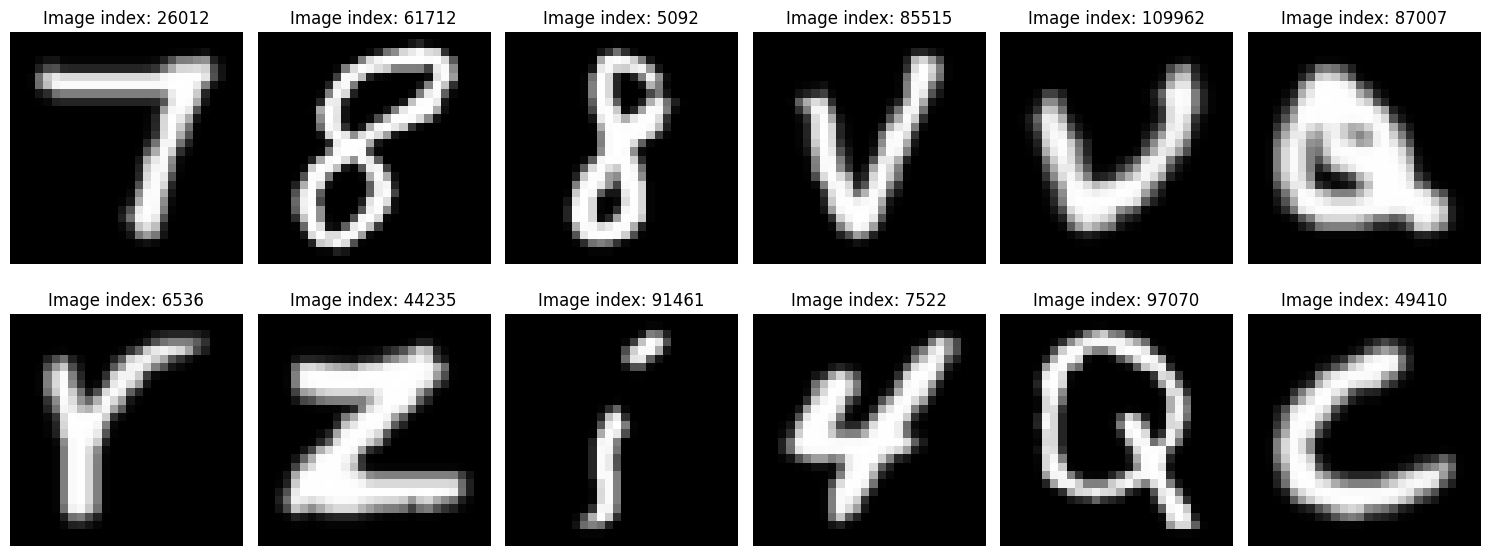

In [8]:
# Visualizing the data to see a few arbitrary images from the dataset
def visualize_samples(data, sample_indices, figsize=(15, 6)):
    """
    Visualizes a set of images from the provided dataset.

    :param data: The dataset containing the images.
    :param sample_indices: A list of indices for the images to be visualized.
    :param figsize: Size of the figure for the plots.
    """
    plt.figure(figsize=figsize)

    for i, img_index in enumerate(sample_indices):
        plt.subplot(2, 6, i + 1)
        plt.imshow(data[img_index][:, :, 0], cmap='gray')
        plt.title(f'Image index: {img_index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Number of samples to visualize
num_samples = 12

# Randomly select indices for the samples
random_indices = np.random.choice(len(x_train), num_samples, replace=False)

# Visualize the sampled images
visualize_samples(x_train, random_indices)

<a id="Model Architecture"></a>
## Model Architecture


Autoencoders consist of two main parts:

1. **Encoder:** This part of the network compresses the input into a latent-space representation. It encodes the input data as a compressed representation in a reduced dimension. The encoder layer is typically followed by several hidden layers that help the network learn complex patterns in the data.

In [9]:
# Encoder

# Input Layer: Defines the shape of the input data for the encoder.
encoder_input_layer = Input(shape=input_dimensions, name='encoder_input_layer')

# Convolution Layers: Applies convolution operations to extract features from the input image.
encoder_layer = Conv2D(32, 3, padding='same', activation='relu')(encoder_input_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)
encoder_layer = Conv2D(64, 3, padding='same', activation='relu')(encoder_layer)

# Flattening Layer: Converts the 3D output of convolution layers into a 1D tensor for dense layers.
encoder_layer = Flatten()(encoder_layer)

# Dense Layer: A fully connected layer that combines extracted features and performs further learning.
encoder_layer = Dense(32, activation='relu')(encoder_layer)

# Storing the output shape for use in the decoder
encoder_output_shape = K.int_shape(encoder_layer)
print(f"Output shape of encoder: {encoder_output_shape}")

Output shape of encoder: (None, 32)


In [10]:
# Building the encoder model
encoder_model = Model(encoder_input_layer, encoder_layer, name='encoder_model')

# Display the model summary
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_layer (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                     

2. **Decoder:** The decoder part of the network reconstructs the input data from the latent space representation. The aim is to produce an output that is as close as possible to the original input. Like the encoder, the decoder is also typically comprised of several layers.

In [11]:
# Decoder

# Input to the Decoder (same shape as the encoder's output)
decoder_input = Input(shape=(encoder_output_shape[-1],), name='decoder_input')

# Calculate the shape required to reshape the flattened data
reshape_dim = (input_dimensions[0] // 2, input_dimensions[1] // 2, 64)  

# Dense Layer
decoder_layer = Dense(np.prod(reshape_dim), activation='relu')(decoder_input)

# Reshape Layer
decoder_layer = Reshape(reshape_dim)(decoder_layer)

# Transposed Convolution Layers: Reverse the operations of the Conv2D layers in the encoder
decoder_layer = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(64, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(64, 3, padding='same', activation='relu')(decoder_layer)
decoder_layer = Conv2DTranspose(32, 3, padding='same', activation='relu')(decoder_layer)

# Output Layer
decoder_output = Conv2DTranspose(1, 3, padding='same', activation='sigmoid', name='decoder_output')(decoder_layer)

In [12]:
# Build the Decoder Model
decoder_model = Model(decoder_input, decoder_output, name='decoder_model')

# Display the model summary
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 12544)             413952    
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 28, 28, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 64)      

In [13]:
# Full Autoencoder Model
autoencoder_input = encoder_input_layer
autoencoder_output = decoder_model(encoder_model.output)
autoencoder = Model(autoencoder_input, autoencoder_output, name='full_autoencoder')

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Display the model summary
autoencoder.summary()

Model: "full_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_layer (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                  

<a id="Model Training"></a>
## Model Training

**Note:** Before training the model, I define callbacks to have more control during model training:

#### (1) Model Checkpoint
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [14]:
model_checkpoint = ModelCheckpoint(
    filepath = '/Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_model_Autoencoder_model04.keras',
    monitor  = 'val_loss',
    save_best_only = True,
    verbose  = 1,
    mode     = 'min'    # The target, 'val_loss', should be minimized
)

#### (2) Early Stopping
*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time

In [15]:
early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 5,
    verbose  = 1,
    mode     = 'min'    
)

#### (3) Adjusting the learning rate
*   Callback to reduce the learning rate when a metric has stopped improving
*   This helps in achieving smoother convergence through training

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.1,   # Multiplicative factor of learning rate reduction
    patience = 5,
    min_lr   = 0.0001, # Lower bound on the learning rate
    verbose  = 1
)

### Callbacks List

In [17]:
# List of callbacks to be used in model training
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

In [18]:
# Training the Autoencoder
results = autoencoder.fit(
    x_train, x_train,  
    epochs = 15,
    batch_size = 128,
    shuffle = True,
    validation_data = (x_test, x_test), 
    callbacks = callbacks_list
)

Epoch 1/15
882/882 [==============================] - ETA: 0s - loss: 0.0221
Epoch 1: val_loss improved from inf to 0.00967, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_model_Autoencoder_13.keras
882/882 [==============================] - 212s 240ms/step - loss: 0.0221 - val_loss: 0.0097 - lr: 0.0010
Epoch 2/15
882/882 [==============================] - ETA: 0s - loss: 0.0086
Epoch 2: val_loss improved from 0.00967 to 0.00804, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_model_Autoencoder_13.keras
882/882 [==============================] - 210s 238ms/step - loss: 0.0086 - val_loss: 0.0080 - lr: 0.0010
Epoch 3/15
882/882 [==============================] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss improved from 0.00804 to 0.00729, saving model to /Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/best_model_Autoencoder_13.keras
882/882 [==============================] - 211s 240ms/step - loss: 0.0075 - val_loss: 0.0073 - lr: 0.0010

<a id="Model Evaluation"></a>
## Model Evaluation

#### Model Training History Analysis:

In [19]:
# Extracting loss values for training and validation sets
loss = results.history['loss']                      # Training loss
val_loss = results.history['val_loss']              # Validation loss

print("Training Loss: ", loss[-1])
print("Validation Loss: ", val_loss[-1])

Training Loss:  0.0050644357688724995
Validation Loss:  0.005331302061676979


#### Training and Validation Losses plot:

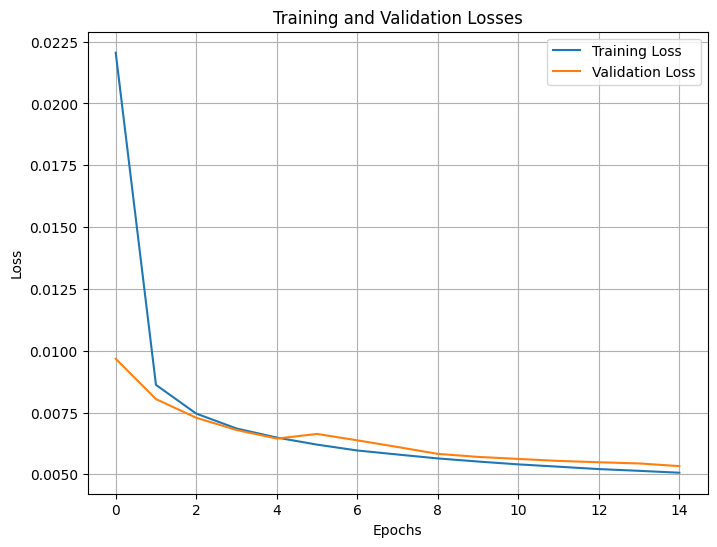

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Visual Inspection

One of the common methods to estimate the loss of information through autoencoder model is simply looking at the reconstructed images and comparing them with the originals.

588/588 [==============================] - 18s 31ms/step


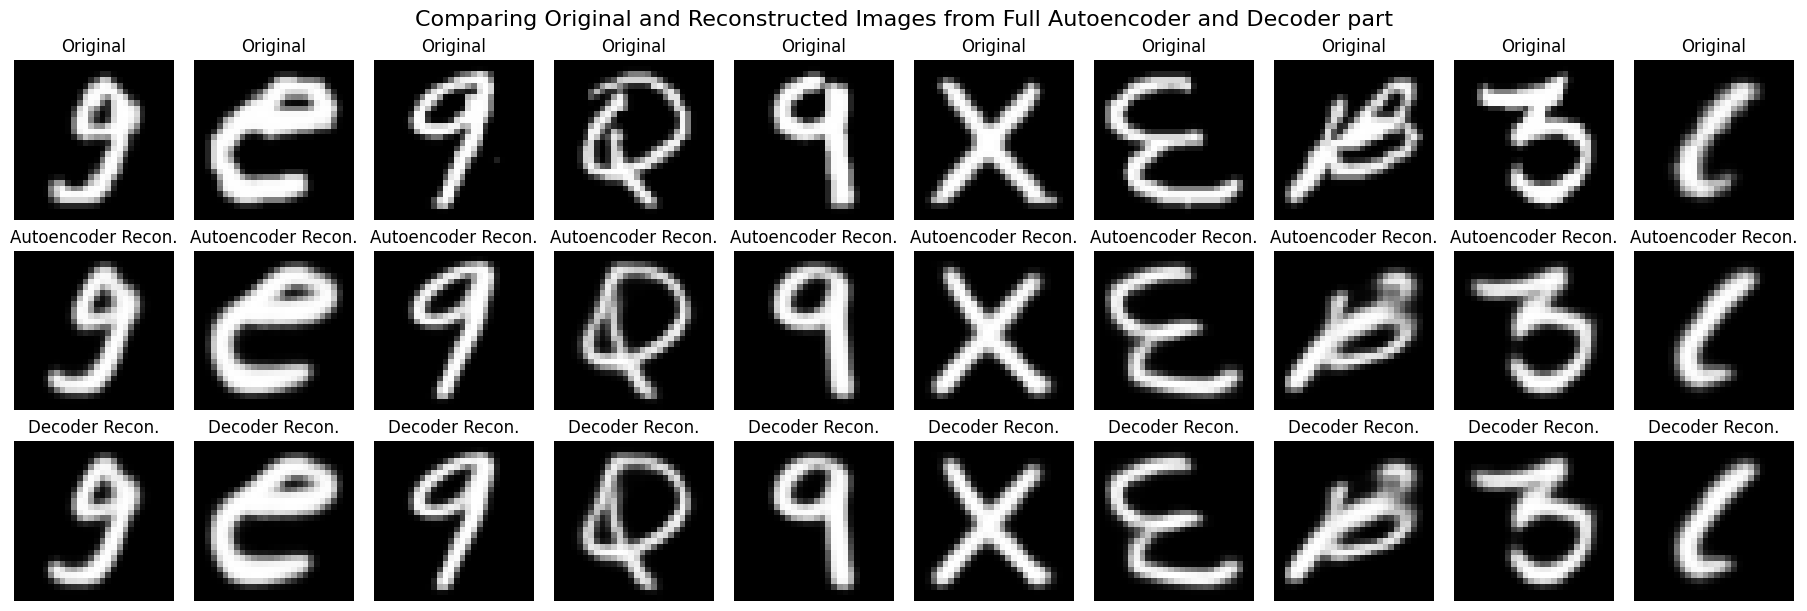

In [21]:
# Obtain encoded representations (compressed form) of test images
encoded_imgs = encoder_model.predict(x_test)

# Reconstruct images using the full autoencoder model
reconstructed_images_autoencoder = autoencoder.predict(x_test)

# Reconstruct images using the decoder model only
reconstructed_images_decoder = decoder_model.predict(encoded_imgs)

# Visualization of original and reconstructed images
num_images = 10
fig, axes = plt.subplots(3, num_images, figsize=(18, 6), constrained_layout=True)

for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    original_img = x_test[i].reshape(28, 28)
    ax.imshow(original_img, cmap='gray')
    ax.axis('off')
    ax.set_title("Original")

    # Display reconstruction from Full Autoencoder
    ax = axes[1, i]
    reconstructed_img_autoencoder = reconstructed_images_autoencoder[i].reshape(28, 28)
    ax.imshow(reconstructed_img_autoencoder, cmap='gray')
    ax.axis('off')
    ax.set_title("Autoencoder Recon.")

    # Display reconstruction from Decoder model only
    ax = axes[2, i]
    reconstructed_img_decoder = reconstructed_images_decoder[i].reshape(28, 28)
    ax.imshow(reconstructed_img_decoder, cmap='gray')
    ax.axis('off')
    ax.set_title("Decoder Recon.")

plt.suptitle("Comparing Original and Reconstructed Images from Full Autoencoder and Decoder part", fontsize=16)
plt.show()


In [22]:
# Random Sample
num_img_sample = 10  
indices = np.random.choice(range(len(x_test)), size=num_img_sample, replace=False)

# Original random images
original_images = x_test[indices]

# Generate reconstructed images using decoding encoded images 
# Since the encoder output shape is (None, 32), it matches the decoder input
latent_representation     = encoder_model.predict(original_images)
reconstructed_img_decoder = decoder_model.predict(latent_representation)

# Generate reconstructed images using the full autoencoder
reconstructed_img_autoencoder = autoencoder.predict(original_images)

1/1 [==============================] - 0s 27ms/step


#### Basic Image Quality Metrics (MSE, SSIM, PSNR)

1. **Mean Squared Error (MSE):** A statistical measure that calculates the average of the squares of the errors or deviations, specifically the difference between original and estimated values.

In [23]:
# Function to calculate MSE
def calculate_mse(original, reconstructed):
    mse = MeanSquaredError()
    mse.update_state(original, reconstructed)
    return mse.result().numpy()

mse_autoencoder = calculate_mse(original_images, reconstructed_img_autoencoder)
mse_decoder     = calculate_mse(original_images, reconstructed_img_decoder)

print("MSE with Autoencoder:", mse_autoencoder)
print("MSE with Decoder:", mse_decoder)

MSE with Autoencoder: 0.0046826783
MSE with Decoder: 0.0046826783


2. **Structural Similarity Index (SSIM):** A metric used to measure the similarity between two images, considering changes in luminance, contrast, and structure, rather than focusing on pixel-level differences.

In [24]:
# Function to calculate SSIM
def calculate_ssim(original, reconstructed):
    # If images have a channel dimension, remove it
    if original.ndim == 3 and original.shape[-1] == 1:
        original = original.squeeze(-1)
    if reconstructed.ndim == 3 and reconstructed.shape[-1] == 1:
        reconstructed = reconstructed.squeeze(-1)
    return ssim(original, reconstructed, multichannel=False, win_size=11, data_range=1.0)  

# Calculate SSIM for autoencoder and decoder reconstructed images
ssim_autoencoder = np.mean([calculate_ssim(o, r) for o, r in zip(original_images, reconstructed_img_autoencoder)])
ssim_decoder     = np.mean([calculate_ssim(o, r) for o, r in zip(original_images, reconstructed_img_decoder)])

print("SSIM with Autoencoder:", ssim_autoencoder)
print("SSIM with Decoder:", ssim_decoder)

SSIM with Autoencoder: 0.9694286496918878
SSIM with Decoder: 0.9694286496918878


3. **Peak Signal-to-Noise Ratio (PSNR):** A measure used to assess the quality of a reconstructed image, comparing it to the original by calculating the ratio of the maximum possible power of a signal to the power of distorting noise.

In [25]:
# Function to calculate PSNR
def calculate_psnr(original, reconstructed):
    return psnr(original, reconstructed, data_range=original.max() - original.min())

# Calculate PSNR for autoencoder and decoder reconstructed images
psnr_autoencoder = np.mean([calculate_psnr(o, r) for o, r in zip(original_images, reconstructed_img_autoencoder)])
psnr_decoder     = np.mean([calculate_psnr(o, r) for o, r in zip(original_images, reconstructed_img_decoder)])

print("PSNR with Autoencoder:", psnr_autoencoder)
print("PSNR with Decoder:", psnr_decoder)


PSNR with Autoencoder: 23.9010523576152
PSNR with Decoder: 23.9010523576152


#### Save the trained encoder and decoder models for future use

In [26]:
# Save the trained encoder model for future use (data compression)
encoder_model.save('/Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/trained_encoder_model_EMNIST_model04.keras')

In [27]:
# Save the trained decoder model for future use (data recunstruction)
decoder_model.save('/Volumes/D/GitHub-Portfolio/CompressNetMNIST/models/trained_decoder_model_EMNIST_model04.keras')